In [22]:
import pandas as pd 
import csv
import numpy as np
import matplotlib.pyplot as plt 
import math
from statsmodels.tsa import stattools
from statsmodels.tsa import arima_model
from statsmodels.graphics import gofplots
from statsmodels.regression import linear_model
from scipy import stats
import scipy.integrate
import scipy.special
import yfinance as yf
from sklearn.linear_model import LinearRegression
import statistics

In [23]:
#read the list of tickers from a csv file and print them out
tickers_file = 'TechTickers_hw3.csv'
tickers = [];
f = open(tickers_file,"r",encoding='utf-8-sig')
for line in csv.reader(f):
    tickers.append(str(line[0]))
f.close
tickers_str = tickers[0]
for s in tickers[1:]: tickers_str=tickers_str+" "+s
print(tickers)

['AAPL', 'MSFT', 'TSM', 'INTC', 'CSCO', 'ORCL', 'SAP', 'ADBE', 'CRM', 'NVDA', 'ACN', 'ASML', 'TXN', 'IBM', 'QCOM', 'FIS', 'INTU', 'MU', 'VMW', 'AMAT', 'AMD', 'ADI', 'LRCX', 'INFY', 'ADSK', 'CTSH', 'TEL', 'APH', 'HPQ', 'CAJ', 'ERIC', 'MSI', 'KLAC', 'MCHP', 'XLNX', 'STM', 'VRSN', 'GLW', 'GIB', 'ANSS', 'SNPS', 'WDC', 'SWKS', 'CDNS', 'GRMN', 'MRVL', 'CHKP', 'STX', 'CTXS', 'AKAM', 'NTAP', 'BR', 'IT', 'LDOS', 'ZBRA', 'TDY', 'OTEX', 'TYL', 'TER', 'FICO', 'JKHY', 'ASX']


In [24]:
#downoad the prices and volumes for the previously read list of tickers
start_date = '2021-01-01'
end_date = '2021-12-30'
stock_data = yf.download(tickers_str, start=start_date, end=end_date)

[*********************100%***********************]  62 of 62 completed


In [25]:
#print(stock_data)
price = stock_data['Adj Close'].values
days = price.shape[0]
print(price)
print(days)

[[128.45343018 252.67366028 485.33999634 ...  52.22999954 141.90472412
  378.13000488]
 [130.04161072 254.11210632 485.69000244 ...  53.06000137 143.69807434
  380.57000732]
 [125.66420746 256.89044189 466.30999756 ...  53.40999985 140.69918823
  394.82000732]
 ...
 [180.10054016 414.25598145 577.67999268 ...  62.09000015 222.37364197
  606.33001709]
 [179.06185913 414.19613647 569.35998535 ...  62.84000015 219.8682251
  597.32000732]
 [179.15174866 414.34579468 569.28997803 ...  66.12999725 217.22305298
  601.11999512]]
250


In [26]:
# price_test = stock_data['Adj Close']['AAPL'].values
# price_test = price_test[0:60]
# print(len(price_test))

Needed Functions

In [27]:
def get_all_pairs(data): # Function to get all the pairs needed
    tab_pairs = []
    for i in range(len(data)-1):
        for j in range(i+1,len(data)):
            pairs = [data[i],data[j]]
            tab_pairs.append(pairs)
    return tab_pairs

In [28]:
# TEST FUNCTION: All the pairs: 1891 pairs OK
my_pairs = get_all_pairs(tickers)

In [29]:
def get_c(price,price2): # Function to compute the co-integration coefficient Cij
    cij = 0
    test_need = 1 # if cij real and positive, we need to test then Z stationary enough

    dx = [np.diff(price[:-1])]
    dx.append(np.diff(price2[:-1]))
    dx = np.array(dx).T

    dy = [np.diff(price[1:])]
    dy.append(np.diff(price2[1:]))
    dy = np.array(dy).T

    reg_results = LinearRegression().fit(dx,dy)
    phi = reg_results.coef_+np.identity(2)

    rho, v = np.linalg.eig(phi.T)
    c2_0 = -v[1,0]/v[0,0]
    c2_1 = -v[1,1]/v[0,1]


    if (c2_0>0 and rho[0].imag==0) and (c2_1>0 and rho[1].imag==0) :  # if the cij are real and positive, we take the smallest p-value
        z2_0 = np.array(price)-np.array(price2)*c2_0
        z2_1 = np.array(price)-np.array(price2)*c2_1
        df_test_c2_0 = stattools.adfuller(z2_0,2,'c',None)
        df_test_c2_1 = stattools.adfuller(z2_1,2,'c',None)
        if df_test_c2_0[1] < df_test_c2_1[1]:
            cij = c2_0
        else:
            cij = c2_1
    elif (c2_0>0 and rho[0].imag==0) and (c2_1<0 or rho[1].imag!=0):  # Otherwise, we just take the cij that is real and positive
        cij = c2_0
    elif (c2_1>0 and rho[1].imag==0) and (c2_0<0 or rho[0].imag!=0):  # Otherwise, we just take the cij that is real and positive
        cij = c2_1
    else:                                                         # Else, we don't need to test the pair
        test_need = 0

    z = np.array(price) - np.array(price2) * cij
    #z = z-np.mean(z)

    return cij, z, test_need

In [30]:
def cointegrated_pairs(c,Z,p_star,rho_star): # Function to check if the pair is co-integrated
    state = 0                                       # pair not cointegrated
    DF_test = stattools.adfuller(Z,2,'c',None)
    if DF_test[1]<=p_star:                          # we need p-value<=0.01
        phi = linear_model.yule_walker(Z,order=2)
        if np.sum(phi[0])<=rho_star:                # we need sum(phi)<0.7 --> stationary enough
            state = 1                               # pair cointegrated
    return state

In [67]:
N = 60
p_star = 0.01
rho_star = 0.7
time_stop = 20
c = 1000000

tab_follow_up = np.zeros(shape=(len(my_pairs),10))    # array that is continuously updated: stock all the information needed for each pair
tab_follow_up = np.c_[my_pairs,tab_follow_up]         # the first two columns are the ticker involved in the pair

df = pd.DataFrame(tab_follow_up)
for i in range(2,9):
    df[i] = df[i].astype(float)
df.columns =['Stock1', 'Stock2', 'Open/Closed', 'Mu', 'Sigma', 'Cij', 'Holding Time','Del_i','Del_j', 'Position','Initial_del_i','Initial_del_j']

tab_hist_time_closed_fail = []                        # tab to make the histogram about how long does it take to close a pair
tab_hist_time_closed_success = []
tab_failure_num = []
tab_success_pair = []
tab_open_pairs = []
tab_abs_pnl = []

tab_long_capital = []
tab_short_capital = []
final_pnl = [0]
tab_long_PnL = [0]                                    # tab for long side capital
tab_short_PnL = [0]                                   # tab for short side capital


for t in range(N,days-1):
#for t in range(N,N+2):
    print('Time: ',t)
    fail_pairs = 0                                   # pairs closed because of stop-loss condition
    success_pairs = 0                                # pairs closed "normally"
    pairs_index = 0                                  # enable to navigate into the array and to take the right pair
    opened_pairs = 0                                 # pairs currently opened: = opened previously + newly opened

    still_opened = 0
    new_opened = 0
    long_values = []
    short_values = []


    tab_pnl = np.zeros(shape=(len(tickers),2))    # array that is continuously updated: stock all the information needed for each pair
    tab_pnl = np.c_[tickers,tab_pnl]              # the first two columns are the ticker involved in the pair
    df_pnl = pd.DataFrame(tab_pnl)
    for i in range(1,2):
        df_pnl[i] = df_pnl[i].astype(float) # dataframe where I see number of shares in each asset and the changes in each price --> compute PnL thanks to it

    tab_long = np.zeros(shape=(len(tickers),2))
    tab_long = np.c_[tickers,tab_long]
    df_long = pd.DataFrame(tab_long)
    for i in range(1,2):
        df_long[i] = df_long[i].astype(float)

    tab_short = np.zeros(shape=(len(tickers),2))
    tab_short = np.c_[tickers,tab_short]
    df_short = pd.DataFrame(tab_short)
    for i in range(1,2):
        df_short[i] = df_short[i].astype(float)

    tab_l_cap = np.zeros(shape=(len(tickers),2))
    tab_l_cap = np.c_[tickers,tab_l_cap]
    long_capital = pd.DataFrame(tab_l_cap)
    for i in range(1,2):
        long_capital[i] = long_capital[i].astype(float)

    tab_s_cap = np.zeros(shape=(len(tickers),2))
    tab_s_cap = np.c_[tickers,tab_s_cap]
    short_capital = pd.DataFrame(tab_s_cap)
    for i in range(1,2):
        short_capital[i] = short_capital[i].astype(float)


    tab_PnL_to_print = pd.DataFrame({"stock1":[],"stock2":[],"Cij":[] ,"shares_stock1":[], "shares_stock2":[], "position":[]})

    for index, pairs in enumerate(my_pairs):

        price1 = stock_data['Adj Close'][pairs[0]].values       # price of the first ticker
        price1_est = price1[t-N:t]                              # backtesting on the estimation window: 60 values
        price2 = stock_data['Adj Close'][pairs[1]].values       # price of the second ticker
        price2_est = price2[t-N:t]                              # backtesting on the estimation window: 60 values

        index_ticker = df_pnl[df_pnl[0]==str(pairs[0])].index[0]        # Index to update the right ticker
        index_ticker_2 = df_pnl[df_pnl[0]==str(pairs[1])].index[0]      # Index of the second stock

        long_index_ticker = df_long[df_long[0]==str(pairs[0])].index[0]
        long_index_ticker_2 = df_long[df_long[0]==str(pairs[1])].index[0]

        short_index_ticker = df_short[df_short[0]==str(pairs[0])].index[0]
        short_index_ticker_2 = df_short[df_short[0]==str(pairs[1])].index[0]

        lc_index_ticker = long_capital[long_capital[0]==str(pairs[0])].index[0]
        lc_index_ticker_2 = long_capital[long_capital[0]==str(pairs[1])].index[0]

        sc_index_ticker = short_capital[short_capital[0]==str(pairs[0])].index[0]
        sc_index_ticker_2 = short_capital[short_capital[0]==str(pairs[1])].index[0]



        if df.iat[index,2]==1: # If the pair is opened

            Z_test = price1[t]-df.iat[index,5]*price2[t]       # we compute the spread at time t

            if (df.iat[index,2]==1 and df.iat[index,9]==1 and Z_test >= df.iat[index,3]) or (df.iat[index,2]==1 and df.iat[index,9]==0 and Z_test <= df.iat[index,3]):
                # LONG position and going opposite direction

                df.iat[index,2]=0    # we close the pair
                success_pairs += 1
                tab_hist_time_closed_success.append(df.iat[index,6])


                tab_PnL_to_print = tab_PnL_to_print.append( {"stock1":pairs[0],"stock2":pairs[1] ,"Cij":df.iat[index,5],"shares_stock1":df.iat[index,7], "shares_stock2":df.iat[index,8], "position":df.iat[index,9]}, ignore_index=True)

                pairs_index = pairs_index+1
                continue    # forces next iteration

            elif (df.iat[index,2]==1 and df.iat[index,9]==1 and Z_test <= df.iat[index,3]-4*df.iat[index,4]) or (df.iat[index,2]==1 and df.iat[index,9]==0 and Z_test >= df.iat[index,3]+4*df.iat[index,4]):
                # long position and 4sigma condition: failure

                df.iat[index,2]=0    # we close the pair
                fail_pairs += 1
                tab_hist_time_closed_fail.append(df.iat[index,6])

                tab_PnL_to_print = tab_PnL_to_print.append( {"stock1":pairs[0],"stock2":pairs[1] ,"Cij":df.iat[index,5],"shares_stock1":df.iat[index,7], "shares_stock2":df.iat[index,8], "position":df.iat[index,9]}, ignore_index=True)

                pairs_index = pairs_index+1
                continue
            else: # pair not closed
                if df.iat[index,6] > time_stop: # stop-loss condition on long side
                    df.iat[index,2]=0
                    fail_pairs += 1
                    tab_hist_time_closed_fail.append(df.iat[index,6])

                    tab_PnL_to_print = tab_PnL_to_print.append( {"stock1":pairs[0],"stock2":pairs[1] ,"Cij":df.iat[index,5],"shares_stock1":df.iat[index,7], "shares_stock2":df.iat[index,8], "position":df.iat[index,9]}, ignore_index=True)

                    pairs_index = pairs_index+1
                    continue
                else:
                    # we keep the pair opened
                    still_opened+=1
                    df.iat[index,6] = df.iat[index,6]+1 # holding time +1
                    if df.iat[index,9]==1: # long side: we just update delta_shares_i/j

                        df_pnl.iat[index_ticker,1] = df_pnl.iat[index_ticker,1]+df.iat[index,7]
                        df_pnl.iat[index_ticker,2] = price1[t+1]-price1[t]

                        df_pnl.iat[index_ticker_2,1] = df_pnl.iat[index_ticker_2,1] + df.iat[index,8]
                        df_pnl.iat[index_ticker_2,2] = price2[t+1]-price2[t]

                        df_long.iat[long_index_ticker,1] = df_long.iat[long_index_ticker,1] + df.iat[index,7]
                        df_long.iat[long_index_ticker,2] = price1[t+1]-price1[t]

                        df_short.iat[short_index_ticker_2,1] = df_short.iat[short_index_ticker_2,1] + df.iat[index,8]
                        df_short.iat[short_index_ticker_2,2] = price2[t+1]-price2[t]

                        long_capital.iat[lc_index_ticker,1] = long_capital.iat[lc_index_ticker,1] + df.iat[index,7]
                        long_capital.iat[lc_index_ticker,2] = price1[t]

                        short_capital.iat[sc_index_ticker_2,1] = short_capital.iat[sc_index_ticker_2,1] + df.iat[index,8]
                        short_capital.iat[sc_index_ticker_2,2] = price2[t]

                        delta_shares_i = min(c/price1[t],c/(df.iat[index,5]*price2[t]))
                        delta_shares_j = -df.iat[index,5]*delta_shares_i

                        df.iat[index,7] = delta_shares_i
                        df.iat[index,8] = delta_shares_j

                        tab_PnL_to_print = tab_PnL_to_print.append( {"stock1":pairs[0],"stock2":pairs[1] ,"Cij":df.iat[index,5],"shares_stock1":df.iat[index,7], "shares_stock2":df.iat[index,8], "position":df.iat[index,9]}, ignore_index=True)

                    else: # short side: we just update delta_shares_i/j

                        df_pnl.iat[index_ticker,1] = df_pnl.iat[index_ticker,1] + df.iat[index,7]
                        df_pnl.iat[index_ticker,2] = price1[t+1]-price1[t]

                        df_pnl.iat[index_ticker_2,1] = df_pnl.iat[index_ticker_2,1] + df.iat[index,8]
                        df_pnl.iat[index_ticker_2,2] = price2[t+1]-price2[t]

                        df_long.iat[long_index_ticker_2,1] = df_long.iat[long_index_ticker_2,1] + df.iat[index,8]
                        df_long.iat[long_index_ticker_2,2] = price2[t+1]-price2[t]

                        df_short.iat[short_index_ticker,1] = df_short.iat[short_index_ticker,1] + df.iat[index,7]
                        df_short.iat[short_index_ticker,2] = price1[t+1]-price1[t]

                        long_capital.iat[lc_index_ticker_2,1] = long_capital.iat[lc_index_ticker_2,1] + df.iat[index,8]
                        long_capital.iat[lc_index_ticker_2,2] = price2[t]

                        short_capital.iat[sc_index_ticker,1] = short_capital.iat[sc_index_ticker,1] + df.iat[index,7]
                        short_capital.iat[sc_index_ticker,2] = price1[t]

                        delta_shares_i = -min(c/price1[t],c/(df.iat[index,5]*price2[t]))
                        delta_shares_j = -df.iat[index,5]*delta_shares_i

                        df.iat[index,7] = delta_shares_i
                        df.iat[index,8] = delta_shares_j

                        tab_PnL_to_print = tab_PnL_to_print.append( {"stock1":pairs[0],"stock2":pairs[1] ,"Cij":df.iat[index,5],"shares_stock1":df.iat[index,7], "shares_stock2":df.iat[index,8], "position":df.iat[index,9]}, ignore_index=True)

        if df.iat[index,2]==0:                                 # If the pair is closed
            c2,Z2,test_needed = get_c(price1_est,price2_est)   # co-integration constant + spread
            if test_needed == 1:
                state = cointegrated_pairs(c2,Z2,p_star,rho_star)
                if state==1:                                   # if the pair is co-integrated
                    mu_spread = np.mean(Z2)                    # mean of the spread
                    std_spread = np.std(Z2)                    # std of the spread
                    Z_test = price1[t]-c2*price2[t]
                    if Z_test <= mu_spread-std_spread and (Z_test >= mu_spread-4*std_spread): # If the spread smaller than mu-std, then we buy the spread
                        # LONG SIDE
                        #print(pairs)
                        new_opened+=1
                        delta_shares_i = min(c/price1[t],c/(c2*price2[t]))
                        delta_shares_j = -c2*delta_shares_i

                        df.iat[index,2] = 1                   # the pair is opened on 1/ not opened if 0
                        df.iat[index,3] = mu_spread           # stock the mean
                        df.iat[index,4] = std_spread          # stock the std
                        df.iat[index,5] = c2                  # stock the Cij
                        df.iat[index,6] = 1                   # holding time increment
                        df.iat[index,7] = delta_shares_i      # delta_shares_i
                        df.iat[index,8] = delta_shares_j      # delta_shares_j
                        df.iat[index,9] = 1 #Long state       # 1=long the spread ; 0=short the spread
                        df.iat[index,10] = delta_shares_i     # delta_shares_i at the opened time
                        df.iat[index,11] = delta_shares_j     # delta_shares_j at the opening time

                        df_pnl.iat[index_ticker,1] = df_pnl.iat[index_ticker,1]+df.iat[index,7]
                        df_pnl.iat[index_ticker,2] = price1[t+1]-price1[t]

                        df_pnl.iat[index_ticker_2,1] = df_pnl.iat[index_ticker_2,1] + df.iat[index,8]
                        df_pnl.iat[index_ticker_2,2] = price2[t+1]-price2[t]


                    if Z_test >= mu_spread+std_spread and (Z_test <= mu_spread+4*std_spread): # If the spread greater than  mu+std, then we short the spread
                        # SHORT SIDE
                        #print(pairs)
                        new_opened+=1
                        delta_shares_i = -min(c/price1[t],c/(c2*price2[t]))
                        delta_shares_j = -c2*delta_shares_i

                        df.iat[index,2] = 1
                        df.iat[index,3] = mu_spread
                        df.iat[index,4] = std_spread
                        df.iat[index,5] = c2
                        df.iat[index,6] = 1
                        df.iat[index,7] = delta_shares_i
                        df.iat[index,8] = delta_shares_j
                        df.iat[index,9] = 0 #Short state
                        df.iat[index,10] = delta_shares_i     # delta_shares_i at the opened time
                        df.iat[index,11] = delta_shares_j     # delta_shares_j at the opening time

                        df_pnl.iat[index_ticker,1] = df_pnl.iat[index_ticker,1] + df.iat[index,7]
                        df_pnl.iat[index_ticker,2] = price1[t+1]-price1[t]

                        df_pnl.iat[index_ticker_2,1] = df_pnl.iat[index_ticker_2,1] + df.iat[index,8]
                        df_pnl.iat[index_ticker_2,2] = price2[t+1]-price2[t]



        pairs_index = pairs_index+1


    tab_long_PnL.append(tab_long_PnL[-1]+np.dot(df_long[:][1].values,(df_long[:][2].values).astype(float)))
    tab_short_PnL.append(tab_short_PnL[-1]+np.dot(df_short[:][1].values,(df_short[:][2].values).astype(float)))

    tab_long_capital.append(np.dot(long_capital[:][1].values,(long_capital[:][2].values).astype(float)))
    tab_short_capital.append(-np.dot(short_capital[:][1].values,(short_capital[:][2].values).astype(float)))

    final_pnl.append(final_pnl[-1]+np.dot(df_pnl[:][1].values,(df_pnl[:][2].values).astype(float)))

    print(final_pnl)

    print("Dataframe Information Track")
    print(df.head(10))

    print("Detail PnL")
    print(tab_PnL_to_print)

    print("Zoom on shares")
    print(df_pnl)

    opened_pairs = new_opened + still_opened
    tab_failure_num.append(fail_pairs)
    tab_success_pair.append(success_pairs)
    tab_open_pairs.append(opened_pairs)

    print("Open pairs: ",opened_pairs)
    print("Newly opened pairs: ",new_opened)
    print("Still opened: ",still_opened)
    print("Closed: success pairs: ",success_pairs)
    print("Closed: Fail pairs: ",fail_pairs)
    #print()


Time:  60
[0, 52671.402146602006]
Dataframe Information Track
  Stock1 Stock2  Open/Closed   Mu  Sigma  Cij  Holding Time  Del_i  Del_j  \
0   AAPL   MSFT          0.0  0.0    0.0  0.0           0.0    0.0    0.0   
1   AAPL    TSM          0.0  0.0    0.0  0.0           0.0    0.0    0.0   
2   AAPL   INTC          0.0  0.0    0.0  0.0           0.0    0.0    0.0   
3   AAPL   CSCO          0.0  0.0    0.0  0.0           0.0    0.0    0.0   
4   AAPL   ORCL          0.0  0.0    0.0  0.0           0.0    0.0    0.0   
5   AAPL    SAP          0.0  0.0    0.0  0.0           0.0    0.0    0.0   
6   AAPL   ADBE          0.0  0.0    0.0  0.0           0.0    0.0    0.0   
7   AAPL    CRM          0.0  0.0    0.0  0.0           0.0    0.0    0.0   
8   AAPL   NVDA          0.0  0.0    0.0  0.0           0.0    0.0    0.0   
9   AAPL    ACN          0.0  0.0    0.0  0.0           0.0    0.0    0.0   

  Position Initial_del_i Initial_del_j  
0      0.0           0.0           0.0  
1      0

[0, 52671.402146602006, -112218.76217430412, -33684.975502960486, -92143.92802663037, -81820.24240963432, -14448.00656321898, -7805.737911058926, 281133.2702971509, 351423.093833164, 232480.9125622374, 81505.02077057504, 154930.32322303538, 125634.34409586614, -213985.99121081928, -184689.40796084367, -367503.67693028355, -391148.2137005293, -318108.60454328556, -286928.8998145255, 266003.830875471, 587713.0915669026, 819522.801161943, 988552.6579112608, 973580.2773967204, 827973.5093312578, 630682.4018241649, 972150.9603613797, 1286222.60585359, 1497324.0204799317, 1576221.2105693528, 2010189.895858982, 1952494.8350720427, 2096766.0142122065, 2449962.795971236, 2271758.426135828, 2382611.416831604, 2066877.4131438052, 2289998.1403705133, 1849265.7653094062, 1583050.9955193156, 1682315.5280864928, 1563126.0924616875, 1329551.3550474208, 1251922.2219789517, 1201501.5498979848, 1426240.8264998167, 1545780.9488549342, 1792933.9850267014, 2051331.230583132, 1751452.203913706, 1789471.08026

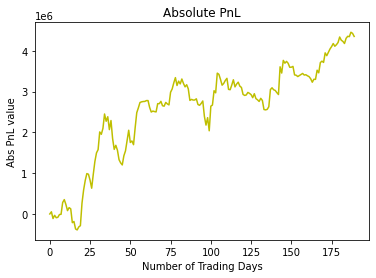

In [68]:
plt.plot(final_pnl, 'y')
plt.title("Absolute PnL")
plt.xlabel("Number of Trading Days")
plt.ylabel("Abs PnL value")
print(final_pnl)


In [69]:
print('Number of opened pairs closed by failure condition: ',np.sum(tab_failure_num))
print('Number of opened pairs closed successfully: ',np.sum(tab_success_pair))

Number of opened pairs closed by failure condition:  163
Number of opened pairs closed successfully:  206


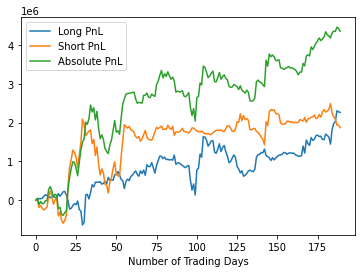

In [71]:
plt.plot(tab_long_PnL)
plt.plot(tab_short_PnL)
plt.plot(final_pnl)
plt.xlabel("Number of Trading Days")
plt.legend(["Long PnL", "Short PnL", "Absolute PnL"], loc ="upper left")

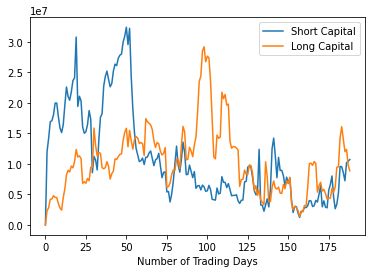

In [73]:
plt.plot(tab_short_capital)
plt.plot(tab_long_capital)
plt.xlabel("Number of Trading Days")
plt.legend(["Short Capital", "Long Capital"], loc ="upper right")

Text(0, 0.5, 'Amount of pairs')

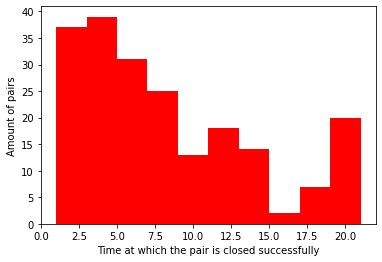

In [74]:
plt.hist(tab_hist_time_closed_success, color="red")
plt.xlabel("Time at which the pair is closed successfully")
plt.ylabel("Amount of pairs")

Text(0, 0.5, 'Amount of pairs')

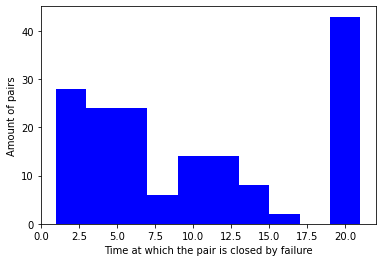

In [75]:
plt.hist(tab_hist_time_closed_fail, color="blue")
plt.xlabel("Time at which the pair is closed by failure")
plt.ylabel("Amount of pairs")

Hedging with S&P500

In [83]:
#print(len(tab_short_capital))
hedging_list = []
final_heging_list = []
for i in range(len(tab_short_capital)):
    hedging_list.append(tab_short_capital[i]-tab_long_capital[i])
#plt.plot(hedging_list)
ticker_name = '^GSPC'
stock_data_snp = yf.download(ticker_name, start=start_date, end=end_date)
price_snp = stock_data_snp['Adj Close'].values
price_snp = price_snp[60:len(price_snp)]
#print(len(price_snp))
#print(len(hedging_list))
for i in range(len(hedging_list)):
    hedging_list[i] = hedging_list[i]/price_snp[i]

for i in range(len(hedging_list)):
    final_heging_list.append(hedging_list[i]*(price_snp[i+1]-price_snp[i]))

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Hedged PnL')

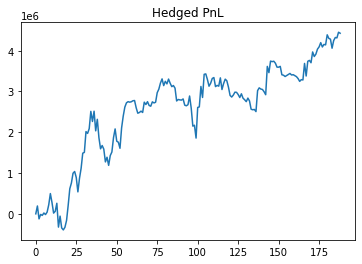

In [86]:
PnL_hedged = []
for i in range(len(final_pnl)-1):
    PnL_hedged.append(final_pnl[i]+final_heging_list[i])
plt.plot(PnL_hedged)
plt.title('Hedged PnL')

Sharpe Ratio computations

In [79]:
def delta_p(T,P):
    somme = 0
    for i in range(1,T):
        somme = somme + (P[i]-P[i-1])
    #print(somme)
    return somme/T

In [80]:
def sharpe(delta_p,T,P):
    somme = 0
    for i in range(1,T):
        somme += ((P[i]-P[i-1]-delta_p)**2)
    den = (somme/(T-1))**0.5
    sharpe_ratio = ((250**0.5)*delta_p)/den
    return sharpe_ratio

In [85]:
delta_abs_p = delta_p(len(final_pnl),final_pnl)
delta_long_p = delta_p(len(tab_long_PnL),tab_long_PnL)
delta_short_p = delta_p(len(tab_short_PnL),tab_short_PnL)

sharpe_ratio_abs = sharpe(delta_abs_p,len(final_pnl),final_pnl)
sharpe_ratio_long = sharpe(delta_long_p,len(tab_long_PnL),tab_long_PnL)
sharpe_ratio_short = sharpe(delta_short_p,len(tab_short_PnL),tab_short_PnL)

delta_hedged = delta_p(len(PnL_hedged),PnL_hedged)
sharpe_ratio_hedged = sharpe(delta_hedged,len(PnL_hedged),PnL_hedged)

print('Absolute PnL Sharpe ratio: ',sharpe_ratio_abs)
print('Long PnL Sharpe ratio: ',sharpe_ratio_long)
print('Short PnL Sharpe ratio: ',sharpe_ratio_short)
print('Hedged PnL Sharpe ratio: ',sharpe_ratio_hedged)

Absolute PnL Sharpe ratio:  2.118350876749855
Long PnL Sharpe ratio:  1.339658249390018
Short PnL Sharpe ratio:  0.9384284771937909
Hedged PnL Sharpe ratio:  1.8052228006992885
